This notebook is for determining between GCC and RNFL thickness values, which one is more rigorous for determing the mean deviation and pattern standard Deviation using XGBOOST regressor. Subsequently we will use the best performing data set to predict Glaucoma using the XGBOOST classifier
-Plan
1. Perform exploratory data analysis to identify needed columns, eliminate irrelevant ones, identify outliers and missing data
2. Split the data into GCC and RNFL subsets with the mean and pattern standard deviations as well as the glaucoma status. 
3. For each of the subset, we will split the data into training and testing set train the model using XGBOOST regressor
4. Train the model on the training set and test the data using the testing set
5. Evaluate the model performance using mean squared error
6. Using the best performing subset, add age, sex, CDR, and IOP measurement to predict glaucoma using XGBOOST classifier
7. Evaluate the model performance using confusion matrix, AUC and an ROC curve. 
8. Just visualization of the confusion matrix

In [135]:
#Importing the libraries of interest
%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, mean_squared_error, roc_curve, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier, XGBRegressor

In [136]:
#importing the file of interest
data= pd.read_csv('/Users/Godfred King/Desktop/Python/Glaucoma/mercydata.csv')
data.head()

,code,no,laterality,Age,Sex,VA,IOP,CDR,gcc_average,gcc_superior,...,rGSS,rGSS_code1,rGSS_code2,GCC_GSS,gcc_GSS_code1,gcc_GSS_code2,gccGSS_code,gccsq,glvsq,mdsq
0,gss094,17657,l,36,m,0.0,22,0.60,103.98,107.65,...,normal,0,0,suspect,1,,3.5,10811.8404,2.433600,0.6084
1,gss011,8197,l,36,m,0.0,16,0.80,94.38,93.32,...,suspect,1,0,suspect,1,,,8907.5844,17.380561,0.0144
2,gss079,16166,r,69,m,0.3,10,0.30,94.61,97.11,...,suspect,1,0,suspect,1,,,8951.0521,11.854249,1.4641
3,gss056,12092,l,47,m,0.3,17,0.50,96.05,95.73,...,suspect,1,0,suspect,1,,,9225.6025,5.564881,0.8836
4,gss047,11583,l,61,f,0.0,18,0.55,99.13,97.94,...,suspect,1,0,suspect,1,,3.5,9826.7569,2.951524,1.7956


In [137]:

print(data.columns)

Index(['code', 'no', 'laterality', 'Age', 'Sex', 'VA', 'IOP', 'CDR',
       'gcc_average', 'gcc_superior', 'gcc_inferior', 'gcc_flv', 'gcc_glv',
       'rnfl_total', 'rnfl_INF', 'rnfl_SUP', 'rnfl_NAS', 'rnfl_TEMP',
       'rnfl_ST', 'rnfl_SN', 'rnfl_TU', 'rnfl_TL', 'rnfl_IT', 'rnfl_IN',
       'rnfl_NL', 'rnfl_NU', 'ONH_rimvolume', 'ONH_nerveheadvol',
       'ONH_cupvolume', 'discarea', 'cup_disc_ratio', 'horizontalcdr',
       'verticalcdr', 'rimarea', 'cuparea', 'FH', 'glaucoma_status',
       'gs_code1', 'MD', 'PSD', 'HPA', 'HPA_code1', 'HPA_code2', 'GSS',
       'GSS_code1', 'GSS_code2', 'rGSS', 'rGSS_code1', 'rGSS_code2', 'GCC_GSS',
       'gcc_GSS_code1', 'gcc_GSS_code2', 'gccGSS_code', 'gccsq', 'glvsq',
       'mdsq'],
      dtype='object')


In [138]:
#Removing the unwanted columns from the DataFrame
data= data[['Age', 'Sex', 'VA', 'IOP', 'CDR',
       'gcc_average', 'gcc_superior', 'gcc_inferior', 'gcc_flv', 'gcc_glv',
       'rnfl_total', 'rnfl_INF', 'rnfl_SUP', 'rnfl_NAS', 'rnfl_TEMP',
       'rnfl_ST', 'rnfl_SN', 'rnfl_TU', 'rnfl_TL', 'rnfl_IT', 'rnfl_IN',
       'rnfl_NL', 'rnfl_NU',
       'gs_code1', 'MD', 'PSD']]
data.head()

,Age,Sex,VA,IOP,CDR,gcc_average,gcc_superior,gcc_inferior,gcc_flv,gcc_glv,...,rnfl_SN,rnfl_TU,rnfl_TL,rnfl_IT,rnfl_IN,rnfl_NL,rnfl_NU,gs_code1,MD,PSD
0,36,m,0.0,22,0.60,103.98,107.65,100.33,0.835,1.560,...,143,89,80,161,161,95,102,1,-3.12,2.20
1,36,m,0.0,16,0.80,94.38,93.32,95.44,0.264,4.169,...,149,73,62,126,131,84,96,1,-3.14,1.10
2,69,m,0.3,10,0.30,94.61,97.11,92.11,0.505,3.443,...,151,79,74,172,134,73,83,1,-3.17,1.05
3,47,m,0.3,17,0.50,96.05,95.73,96.37,0.436,2.359,...,121,93,73,132,90,54,58,1,-3.21,1.69
4,61,f,0.0,18,0.55,99.13,97.94,100.34,0.042,1.718,...,144,84,81,159,124,67,74,1,-3.21,3.50


##### Converting sex into a machine readable numbers
        * males = 0
        * females= 1

In [139]:
data['Sex']= data['Sex'].apply(lambda x: 0 if x== 'm' else 1)

In [140]:
data.head()

,Age,Sex,VA,IOP,CDR,gcc_average,gcc_superior,gcc_inferior,gcc_flv,gcc_glv,...,rnfl_SN,rnfl_TU,rnfl_TL,rnfl_IT,rnfl_IN,rnfl_NL,rnfl_NU,gs_code1,MD,PSD
0,36,0,0.0,22,0.60,103.98,107.65,100.33,0.835,1.560,...,143,89,80,161,161,95,102,1,-3.12,2.20
1,36,0,0.0,16,0.80,94.38,93.32,95.44,0.264,4.169,...,149,73,62,126,131,84,96,1,-3.14,1.10
2,69,0,0.3,10,0.30,94.61,97.11,92.11,0.505,3.443,...,151,79,74,172,134,73,83,1,-3.17,1.05
3,47,0,0.3,17,0.50,96.05,95.73,96.37,0.436,2.359,...,121,93,73,132,90,54,58,1,-3.21,1.69
4,61,1,0.0,18,0.55,99.13,97.94,100.34,0.042,1.718,...,144,84,81,159,124,67,74,1,-3.21,3.50


In [141]:
patients= data[data['gs_code1']==1]
normals= data[data['gs_code1']==0]

Text(0.5, 1.0, 'Age Distribution for the dataset')

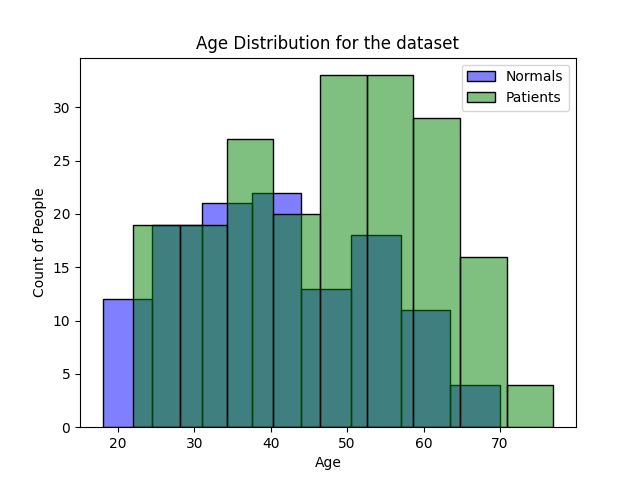

In [142]:
# Ploting the age distribution for the data set
plt.figure()

sns.histplot(normals['Age'], alpha=0.5, color='blue',label='Normals')
sns.histplot(patients['Age'], alpha=0.5, color='green',label='Patients')
plt.legend(loc='upper right')
plt.ylabel('Count of People')
plt.title('Age Distribution for the dataset')

##### The histogram shows that the age of the patients was relatively higher than that of the normals 

In [143]:
data.dtypes

Age               int64
Sex               int64
VA              float64
IOP               int64
CDR             float64
gcc_average     float64
gcc_superior    float64
gcc_inferior    float64
gcc_flv         float64
gcc_glv         float64
rnfl_total      float64
rnfl_INF          int64
rnfl_SUP          int64
rnfl_NAS          int64
rnfl_TEMP         int64
rnfl_ST           int64
rnfl_SN           int64
rnfl_TU           int64
rnfl_TL           int64
rnfl_IT           int64
rnfl_IN           int64
rnfl_NL           int64
rnfl_NU           int64
gs_code1          int64
MD              float64
PSD             float64
dtype: object

In [144]:

#Using a dictionary to count the number of missing values in every column
missingval= dict()
for column in data.columns:
    num=data[column].isnull().count()
    missingval[column]=num
pd.Series(missingval,index=missingval.keys())
#There is no missing data in the dataframe. Uncomment to see which the series

Age             320
Sex             320
VA              320
IOP             320
CDR             320
gcc_average     320
gcc_superior    320
gcc_inferior    320
gcc_flv         320
gcc_glv         320
rnfl_total      320
rnfl_INF        320
rnfl_SUP        320
rnfl_NAS        320
rnfl_TEMP       320
rnfl_ST         320
rnfl_SN         320
rnfl_TU         320
rnfl_TL         320
rnfl_IT         320
rnfl_IN         320
rnfl_NL         320
rnfl_NU         320
gs_code1        320
MD              320
PSD             320
dtype: int64

c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    200
0    120
Name: gs_code1, dtype: int64

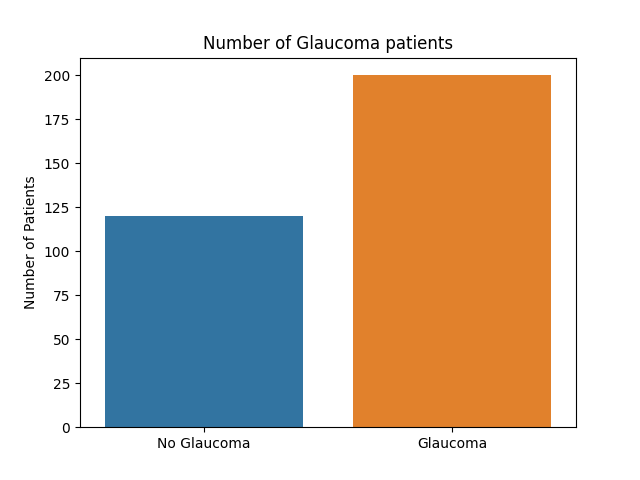

In [145]:
#Counting the number of Glaucoma patients in the dataset
glaucoma= pd.value_counts(data['gs_code1'])
plt.figure()
sns.barplot(glaucoma.index, glaucoma.values)
plt.title('Number of Glaucoma patients')
plt.xticks([0,1],['No Glaucoma','Glaucoma'])
plt.ylabel('Number of Patients')
glaucoma

In [146]:
#Splitting the data into the GCC and RNFL subsets
gcc_data= data[['gcc_average', 'gcc_superior', 'gcc_inferior', 'gcc_flv', 'gcc_glv','gs_code1']]
rnfl_data= data[['rnfl_total', 'rnfl_INF', 'rnfl_SUP', 'rnfl_NAS', 'rnfl_TEMP',
       'rnfl_ST', 'rnfl_SN', 'rnfl_TU', 'rnfl_TL', 'rnfl_IT', 'rnfl_IN',
       'rnfl_NL', 'rnfl_NU','gs_code1']]
#,'MD','PSD','gs_code1'

Visualizing the GCC data and the RNFL data to determine if there are any outliers.
Remember to clean up the boxplots. Just one boxplot showing for both normals and those with glaucoma.

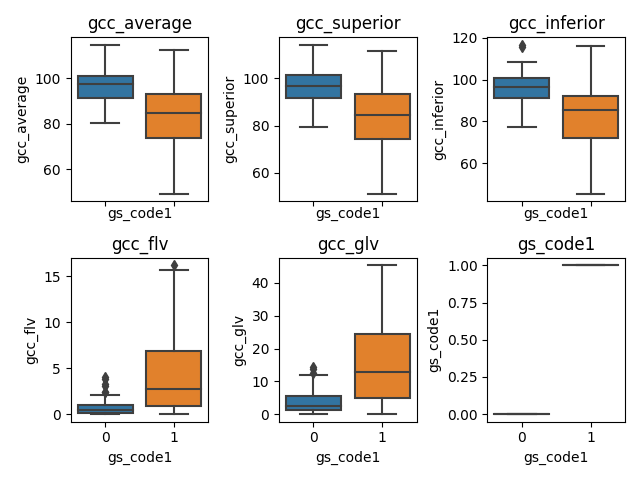

In [168]:
#Using a boxplot to visualize the Gcc data  
gcc_cols=list(gcc_data.columns)
fig,((ax1,ax2,ax3),(ax4,ax5,_))=plt.subplots(2,3, sharey=False, tight_layout=True, sharex=True)
axes= list(fig.axes)
for i in range(len(gcc_cols)):
    sns.boxplot(x=gcc_data['gs_code1'], y=gcc_data[gcc_cols[i]], ax=axes[i])
    # axes[i].boxplot(gcc_neg[gcc_cols[i]])
    axes[i].set_title(gcc_cols[i])


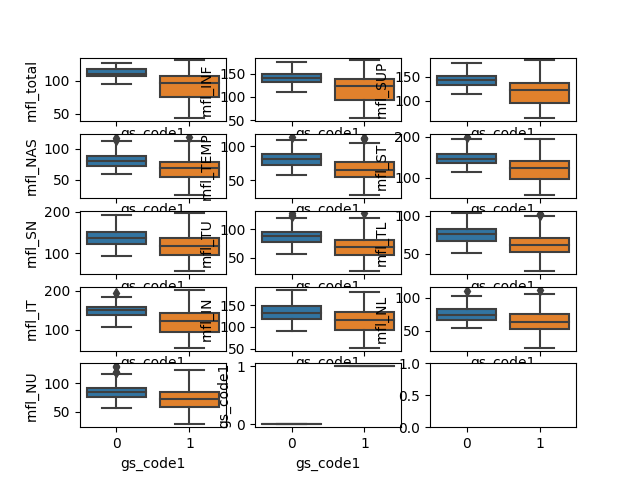

In [169]:
#Using the boxplot to visualize the RNFL data
rnfl_cols= list(rnfl_data.columns)
rnfl_cols
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12),(ax13,ax14,ax15))=plt.subplots(5,3,sharex=True)
axes=list(fig.axes)
for i in range(len(rnfl_cols)):
    sns.boxplot(x=rnfl_data['gs_code1'], y=rnfl_data[rnfl_cols[i]], ax=axes[i])
  
    axes[i].set_title(rnfl_cols[i])

According to Mercy, the data was manually entered and so the outliers could be as a result of inputting wrong values during the entering process. 
* 1- We will do plot the boxplot for both glaucoma and non-glaucoma patients separately
Handling of the outliers 
* 1- The presence of outliers in the upper range for some of the measures in the normals could be an indication of the early sign of the condition although they have not been officially diagnosed. 
* 2- Write a function to check the z-scores. If the threshold is more than 3 replace the data point with the median for the group.
So for example if datapoint A has glaucoma and one measure of his measures is an outlier, we will replace the point with the median value for glaucoma patient

In [149]:
def outlier_check(data,column):
    '''Returns the indices of the datapoints with outliers for a particular column
    
    Datapoints with z-scores of more than 3    
    '''
    
    threshold=  3 #Split the data into normals and glaucoma patients and determine the mean and standard deviations for each group

    normals= data[data['gs_code1']==0]
    patient= data[data['gs_code1']==1]
    n_mean= np.mean(normals[column])
    p_mean= np.mean(patient[column])
    n_std=  np.std(normals[column])
    p_std= np.std(patient[column])
    n_mid= np.median(normals[column])
    p_mid= np.median(patient[column])

    #Creating a list for the outliers. One for the glaucoma patients and one for the normals
    g_pos= []
    g_neg=[]

    for i in range(len(data[column])):
        #Check for the glaucoma group the datapoint belongs to
        if data.loc[i,'gs_code1']==0:
            z_score= (data.loc[i,column]-n_mean)/n_std
            
            if abs(z_score )> threshold:
                
                #Replace the datapoint with the median for the column
                #data.loc[i, column]=n_mid
                g_neg.append(i)
                
            else:continue
        
        else:
            
            z_score= (data.loc[i,column]-p_mean)/p_std
            if abs(z_score )> threshold:
                
                #Replace the datapoint with the median for the column
                #data.loc[i,column]=p_mid
                g_pos.append(i)
                
            else:
                continue

    return g_pos,g_neg, p_mid,n_mid




 Dealing with the outliers
* For each of the columns, get the postive and negative outliers as well as the positive and negative medians
* Replace the positive outliers with the positive median
* Replace the negative outliers with the negative median
    * Postive and Negative here stands for their glaucoma status

In [150]:
# Cleaning up the outliers for the gcc_data
for i in range(len(gcc_cols[:-1])):
    g_pos, g_neg, p_mid,n_mid = outlier_check(gcc_data, gcc_cols[i])
    if len(g_pos)>0:
        for row in g_pos:
            gcc_data.loc[row,gcc_cols[i]] = p_mid
            
    if len(g_neg)>0:
        for row in g_neg:
            gcc_data.loc[row, gcc_cols[i]]= n_mid
            

In [ ]:
# Cleaning up the outliers for the rnfl_data
for i in range(len(rnfl_cols[:-1])):
    g_pos, g_neg, p_mid,n_mid = outlier_check(rnfl_data, rnfl_cols[i])
    if len(g_pos)>0:
        for row in g_pos:
            rnfl_data.loc[row,rnfl_cols[i]] = p_mid
           
   
    if len(g_neg)>0:
        for row in g_neg:
            rnfl_data.loc[row, rnfl_cols[i]]= n_mid
            
    

### Training and Predicition of the Pattern Standard Deviation with XGBOOST 
#### * Make predictions with the GCC data subset 
#### * Make predictions with the rnfl data subset
##### * Assess model performance with the mean squared error
##### * Using the better predicting dataset in combination with age, IOP, VA to predict glaucoma using XGBOOST
##### * Assess the model performance using AUC and ROC curve and confusion matrix

#### GCC DATA for Pattern Standard Deviation

In [152]:
X_train, X_test,y_train, y_test = train_test_split(gcc_data[gcc_cols[:-1]], data['PSD'] ,random_state=42)

In [153]:
gcc_psd= XGBRegressor(objective='reg:linear',n_estimators=10, seed= 21)

In [154]:
gcc_psd.fit(X_train, y_train)

[12:18:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [155]:
gcc_psd_pred= gcc_psd.predict(X_test)
gcc_rsme=round(np.sqrt(mean_squared_error(y_test, gcc_psd_pred)),3)
print('Square root of the mean squared error for Pattern Standard Deviation Prediction using the GCC data is {}'. format(gcc_rsme))

Square root of the mean squared error for Pattern Standard Deviation Prediction using the GCC data is 2.486


#### RNFL DATA for Pattern Standard Deviation

In [156]:
X_train, X_test, y_train, y_test= train_test_split(rnfl_data[rnfl_cols[:-1]], data['PSD'], random_state=24)


In [157]:
rnfl_psd= XGBRegressor(objective='reg:linear', seed= 12, n_estimators= 10)


In [158]:
rnfl_psd.fit(X_train, y_train)


[12:18:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [159]:
rnfl_pred=rnfl_psd.predict(X_test)
rnfl_rsme=round(np.sqrt(mean_squared_error(y_test, rnfl_pred)),3)
print( 'Square root of the mean squared error for Pattern Standard Deviation using RNFL data is {}'.format(rnfl_rsme))

Square root of the mean squared error for Pattern Standard Deviation using RNFL data is 2.583


#### * Square Root of the Mean Squared Error was used as the metric for evaluating the intials models. 
##### * Ganglion Cell Complex had an RMSE of 2.486 
##### * Retinal Nerve Fibre Layer had an RMSE of 2.583
##### * The Ganglion Cell Complex had a better model performance as compared to the Retinal nerve Fibre layer. However, the difference in performance between the two models was almost negligible 

* Using the Ganglion Cell Complex, we are going to combine other parameters such as age, sex, VA, IOP and CDR to predict Glaucoma using the XGBOOST Classifer

In [160]:
glaucoma=data[['Age', 'Sex', 'VA', 'IOP', 'CDR', 'gcc_average', 'gcc_superior',
       'gcc_inferior', 'gcc_flv', 'gcc_glv']]
glaucoma.head()

,Age,Sex,VA,IOP,CDR,gcc_average,gcc_superior,gcc_inferior,gcc_flv,gcc_glv
0,36,0,0.0,22,0.60,103.98,107.65,100.33,0.835,1.560
1,36,0,0.0,16,0.80,94.38,93.32,95.44,0.264,4.169
2,69,0,0.3,10,0.30,94.61,97.11,92.11,0.505,3.443
3,47,0,0.3,17,0.50,96.05,95.73,96.37,0.436,2.359
4,61,1,0.0,18,0.55,99.13,97.94,100.34,0.042,1.718


In [161]:
X_train, X_test,y_train, y_test= train_test_split(glaucoma, data['gs_code1'], random_state=42, test_size=0.32)


In [162]:
xgb= XGBClassifier(objective='binary:logistic', booster='gbtree',n_estimators= 100, seed=21 )
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [163]:
g_pred= xgb.predict(X_test)
confusion=confusion_matrix(y_test, g_pred)
accuracy= accuracy_score(y_true=y_test, y_pred=g_pred)
area= round(roc_auc_score(y_test, g_pred),3)
print('The accuracy score for the Model is {}'.format(round(accuracy,3)))
print('The Area Under the curve is {}'.format(area))

The accuracy score for the Model is 0.854
The Area Under the curve is 0.833


Text(0.5, 23.52222222222222, 'Model Predictions')

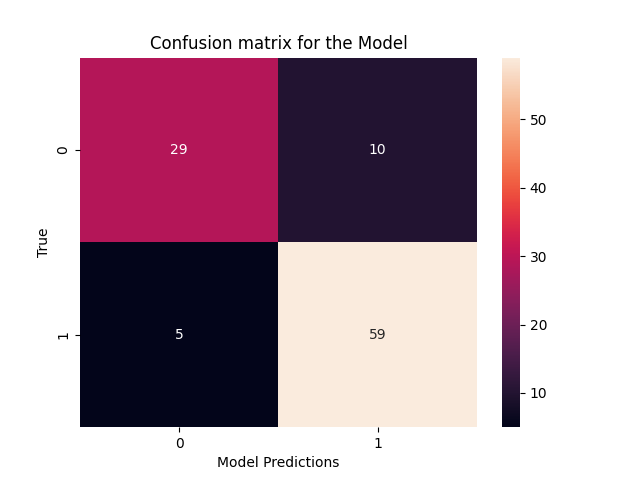

In [164]:
plt.figure()
sns.heatmap(confusion, annot=True)
plt.title('Confusion matrix for the Model')
plt.ylabel('True')
plt.xlabel('Model Predictions')

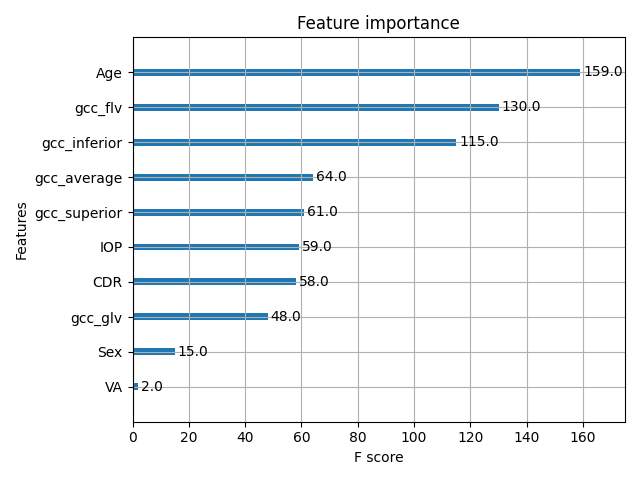

In [167]:
#Plotting the important features in the data
import xgboost as boost
boost.plot_importance(xgb)
plt.tight_layout()

* Age was the biggest feature contribution to the prediction of the glaucoma. It appears the Ganglion Cell Complex global loss volume did not really contribute to prediction of the outcome
* Plotting the ROC curve for the Model 


c:\Users\Godfred King\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Positive Rate')

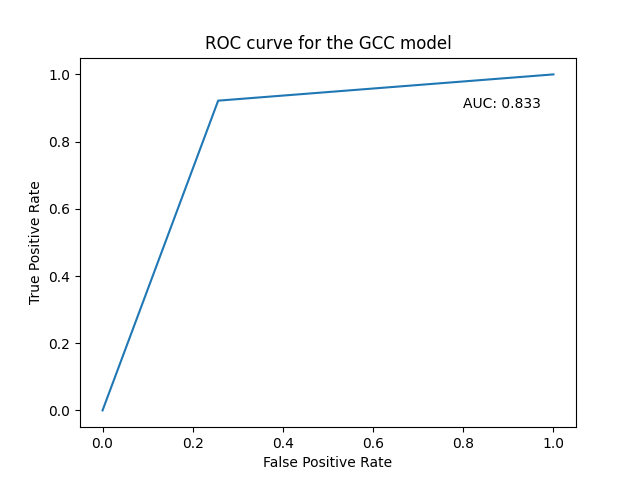

In [166]:
fpr,tpr, thresholds= roc_curve(y_test, g_pred)

plt.figure()
sns.lineplot(fpr, tpr)
plt.title('ROC curve for the GCC model')
plt.annotate('AUC: {}'.format(area),(0.8,0.9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Conclusion
    * A combination of VA, IOP, Sex, Age, CDR and the GCC parameters were used for prediction of glaucoma using XGBOOST
    * Model had an accuracy score of 0.85 and an Area Under Curve metric of 0.84
    * However, Age was the most important factor in predicting of the outcome for the data points
    * Ganglion Cell Complex global loss volume did not contribute much to predicting the outcome
    * An AUC score of 0.83 indicates that the model was a great fit for predicting whether or not a patient had glaucoma

#### Next plan
    *Using the same model parameters, repeat the exercise for the data using the rnfl data rather and the additional columns